Here we demonstrate the generating of linear program, whos feasible region is either empty or not. 

Additionally, we are keeping our decision variables (n) and our constraints (m) constant, since the problem of varying input dimension to our model significnatly increases the complexlixty of the project. This topic will be explored in more detail later in the further research section.

The linear program will take the standard form:
minimize: z = c'x
subject to: Ax <= b
variables: x >= 0

In [2]:
#NOTE: Here We Detail The Generation of Random Linear Programs
#! More Work May Need To Be Done Regarding The Making Of Truly Balanced Data Through Dimensionality and Attribute Varation

import pulp as pl
import numpy as np

def generate_random_linear_program(min=np.random.choice([0,1]), decision_variables=np.random.randint(-10,10), constraints=np.random.randint(-10,10), iteration=0):
    '''
    Creating trivally varible random linear programs.

    TODO:
    >Expand doc string
    >Expand actual todo
    '''
    #? Randomly Determines Whether To Generate A Maximize or Minimize Problem
    if min == 1:
        linear_program = pl.LpProblem(f"Linear_Program_{iteration}", pl.LpMinimize)
    else:
        linear_program = pl.LpProblem(f"Linear_Program_{iteration}", pl.LpMaximize)

    #! Simplifying To Only Lower Bound
    #? Generates a Dictionary of n Decision Variables Then Randomizes Upper or Lower Bound From Zero
    decision_variables = pl.LpVariable.dicts("x", range(decision_variables))
    for variable in decision_variables:
        lower = 1 #np.random.choice([0,1])
        if lower == 1:
            decision_variables[variable].lowBound = 0
        else:
            decision_variables[variable].upBound = 0

    #? For Each Decision Varible Create a Random Constant Such That: 
    #? Objective Function = (Variable 1, Random Constant 1) + (Variable 2, Random Constant 2) + ... + (Variable i, Random Constant i)
    temporary_function = [(decision_variables[i], np.random.randint(-10,10)) for i in range(len(decision_variables))]
    objective_function = pl.LpAffineExpression(temporary_function)
    c_vector = []
    for entry in temporary_function:
        c_vector.append(entry[1])

    #? Adds Objective Function To The Linear Program
    linear_program += objective_function

    #? Generates m Constraints With Random Constants Similar To Objective Function
    a_matrix = []
    b_vector = []
    for _ in range(constraints):
        temporary_function = [(decision_variables[i], np.random.randint(-10,10)) for i in range(len(decision_variables))]
        constraint_function = pl.LpAffineExpression(temporary_function)
        equality_sign = -1 #np.random.choice([-1,1]) #! Simplifying Only <= #? OLD: Constraint Such That >= or <= Random Constant
        equality_value = np.random.randint(-10,10) #? Random Constraint Value
        temporary_constraint = pl.LpConstraint(temporary_function, equality_sign, rhs=equality_value)
        linear_program += temporary_constraint
        a_vector = []
        for entry in temporary_function:
            a_vector.append(entry[1])
        a_matrix.append(a_vector)
        b_vector.append(equality_value)

    return linear_program, a_matrix, b_vector, c_vector

example_linear_program = generate_random_linear_program(min=1, decision_variables=2, constraints=2)
print(example_linear_program)

(Linear_Program_0:
MINIMIZE
1*x_0 + 5*x_1 + 0
SUBJECT TO
_C1: - 9 x_0 + 0 x_1 <= -2

_C2: - 3 x_0 + 4 x_1 <= 1

VARIABLES
x_0 Continuous
x_1 Continuous
, [[-9, 0], [-3, 4]], [-2, 1], [1, 5])


In [3]:
#NOTE: Here We Detial The Creation of Balanced Training Data for the Machine Learning Model
#! More Work May Need To Be Done Regarding The Making Of Truly Balanced Data By Eliminating The Maximum Number Of Biasing Attributes & Increasing Dimensionality

def create_balanced_data(size=1000, bias=None):
    '''
    Creating trivially balanced training data.

    TODO:
    >Expand doc string
    >Expand actual todo
    '''
    n, m = 2, 2
    training_data = []
    last_category = None
    while len(training_data) < size:

        #? Creating Linear Program
        temporary_lp, a_matrix, b_vector, c_vector = generate_random_linear_program(min=1, decision_variables=n, constraints=m)
        solver = pl.PULP_CBC_CMD()

        #* Possible Checking To Eliminate Possible Biasing Attributes, Removed Other Dimensional Attributes Via Randomization Simlification

        #? Formatting Linear Program
        lp_formatted = [a_matrix, b_vector, c_vector]

        #? Solving Linear Program For Data Label Creation
        result = temporary_lp.solve(solver)
        status = pl.LpStatus[temporary_lp.status]

        #? Pairing Data and Label While Balancing Into Training Set
        if bias == None:
            if status == "Optimal" and (last_category == None or last_category == 1):
                lp_category = 0
                training_data.append([lp_formatted, lp_category])
                last_category = 0
            elif status == "Infeasible" and (last_category == None or last_category == 0):
                lp_category = 1
                training_data.append([lp_formatted, lp_category])
                last_category = 1

        elif bias == 0:
            if status == "Optimal":
                lp_category = 0
                training_data.append([lp_formatted, lp_category])
                last_category = 0
        
        elif bias == 1:
            if status == "Infeasible":
                lp_category = 1
                training_data.append([lp_formatted, lp_category])
                last_category = 1

        if bias == -1: #! No Bias
            if status == "Optimal" or "Unbounded":
                lp_category = 0
                training_data.append([lp_formatted, lp_category])
                last_category = 0
            elif status == "Infeasible":
                lp_category = 1
                training_data.append([lp_formatted, lp_category])
                last_category = 1

    return training_data

example_training_data = create_balanced_data(10)
print(f"Example Data Length: {len(example_training_data)}")

category_count = [0,0]
for item in example_training_data:
    if item[1] == 0:
        category_count[0] += 1
    else:
        category_count[1] += 1
print(f"Example Data Balance [Feasible, Infeasible]: {category_count}")
print(f"Example Entry: \n{example_training_data[0]}")


Example Data Length: 10
Example Data Balance [Feasible, Infeasible]: [5, 5]
Example Entry: 
[[[[4, 2], [-1, -2]], [-1, 5], [-7, 0]], 1]


In [4]:
#NOTE: Here We Generate The Training and Testing Data

import random

training_data = create_balanced_data(10000)
print(f"Training Data Length: {len(training_data)}")
category_count = [0,0]
for item in training_data:
    if item[1] == 0:
        category_count[0] += 1
    else:
        category_count[1] += 1
print(f"Training Data Balance [Feasible, Infeasible]: {category_count}")
random.shuffle(training_data)

testing_data = create_balanced_data(5000)
print(f"Testing Data Length: {len(testing_data)}")
category_count = [0,0]
for item in testing_data:
    if item[1] == 0:
        category_count[0] += 1
    else:
        category_count[1] += 1
print(f"Testing Data Balance [Feasible, Infeasible]: {category_count}")
random.shuffle(testing_data)

Training Data Length: 10000
Training Data Balance [Feasible, Infeasible]: [5000, 5000]
Testing Data Length: 5000
Testing Data Balance [Feasible, Infeasible]: [2500, 2500]


In [5]:
#NOTE: Here We Format And Save The Data

import pickle

x_train = []
y_train = []
for features, label in training_data:
    pre_format = np.stack([features[1], features[2]], axis=1)
    x_train.append(np.concatenate([features[0], pre_format], axis=1))
    y_train.append(label)

x_train = np.array(x_train)
pickle_out = open("x_train.pickle","wb")
pickle.dump(x_train, pickle_out)
pickle_out.close()

y_train = np.array(y_train)
pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

x_test = []
y_test = []
for features, label in testing_data:
    pre_format = np.stack([features[1], features[2]], axis=1)
    x_test.append(np.concatenate([features[0], pre_format], axis=1))
    y_test.append(label)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = np.array(x_test)
pickle_out = open("x_test.pickle","wb")
pickle.dump(x_test, pickle_out)
pickle_out.close()

y_test = np.array(y_test)
pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [6]:
#NOTE: Here We Train The Machine Learning Model

import pickle
import tensorflow as tf
from tensorflow import keras

pickle_in = open("x_train.pickle","rb")
x_train = pickle.load(pickle_in)

pickle_in = open("y_train.pickle","rb")
y_train = pickle.load(pickle_in)

pickle_in = open("x_test.pickle","rb")
x_test = pickle.load(pickle_in)

pickle_in = open("y_test.pickle","rb")
y_test = pickle.load(pickle_in)

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train)

val_loss, val_acc = model.evaluate(x_test, y_test)
print(f"Model Error: {val_loss}")
print(f"Model Accuracy: {val_acc}")

157/157 [==============================] - 0s 802us/step - loss: 0.1127 - accuracy: 0.9528
Model Error: 0.11272063851356506
Model Accuracy: 0.9527999758720398


In [7]:
#NOTE: Here We Save The Machine Learning Model

model.save('lp_feasibility.model')

INFO:tensorflow:Assets written to: lp_feasibility.model\assets


In [6]:
#NOTE: Here We Perform Cross Validation

import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.load_model('lp_feasibility.model')

test1_validation_data = create_balanced_data(500) #? Normal Balance
category_count = [0,0]
for item in test1_validation_data:
    if item[1] == 0:
        category_count[0] += 1
    else:
        category_count[1] += 1
print(f"Test 1 Data Balance [Feasible, Infeasible]: {category_count}")
x_validate = []
y_validate = []
for features, label in test1_validation_data:
    pre_format = np.stack([features[1], features[2]], axis=1)
    x_validate.append(np.concatenate([features[0], pre_format], axis=1))
    y_validate.append(label)
x_validate = np.array(x_validate)
y_validate = np.array(y_validate)
val_loss, val_acc = model.evaluate(x_validate, y_validate)
print(f"Model 1 Error: {val_loss}")
print(f"Model 1 Accuracy: {val_acc}")

test2_validation_data = create_balanced_data(500, bias=0) #? Feasible Bias
category_count = [0,0]
for item in test2_validation_data:
    if item[1] == 0:
        category_count[0] += 1
    else:
        category_count[1] += 1
print(f"Test 2 Data Balance [Feasible, Infeasible]: {category_count}")
x_validate = []
y_validate = []
for features, label in test2_validation_data:
    pre_format = np.stack([features[1], features[2]], axis=1)
    x_validate.append(np.concatenate([features[0], pre_format], axis=1))
    y_validate.append(label)
x_validate = np.array(x_validate)
y_validate = np.array(y_validate)
val_loss, val_acc = model.evaluate(x_validate, y_validate)
print(f"Model 2 Error: {val_loss}")
print(f"Model 2 Accuracy: {val_acc}")

test3_validation_data = create_balanced_data(500, bias=1) #? Infeasible Bias
category_count = [0,0]
for item in test3_validation_data:
    if item[1] == 0:
        category_count[0] += 1
    else:
        category_count[1] += 1
print(f"Test 3 Data Balance [Feasible, Infeasible]: {category_count}")
x_validate = []
y_validate = []
for features, label in test3_validation_data:
    pre_format = np.stack([features[1], features[2]], axis=1)
    x_validate.append(np.concatenate([features[0], pre_format], axis=1))
    y_validate.append(label)
x_validate = np.array(x_validate)
y_validate = np.array(y_validate)
val_loss, val_acc = model.evaluate(x_validate, y_validate)
print(f"Model 3 Error: {val_loss}")
print(f"Model 3 Accuracy: {val_acc}")

test4_validation_data = create_balanced_data(1000, bias=-1) #? No Bias
category_count = [0,0]
for item in test4_validation_data:
    if item[1] == 0:
        category_count[0] += 1
    else:
        category_count[1] += 1
print(f"Test 4 Data Balance [Feasible, Infeasible]: {category_count}")
x_validate = []
y_validate = []
for features, label in test4_validation_data:
    pre_format = np.stack([features[1], features[2]], axis=1)
    x_validate.append(np.concatenate([features[0], pre_format], axis=1))
    y_validate.append(label)
x_validate = np.array(x_validate)
y_validate = np.array(y_validate)
val_loss, val_acc = model.evaluate(x_validate, y_validate)
print(f"Model 4 Error: {val_loss}")
print(f"Model 4 Accuracy: {val_acc}")

Test 1 Data Balance [Feasible, Infeasible]: [250, 250]
16/16 [==============================] - 0s 786us/step - loss: 0.8843 - accuracy: 0.9200
Model 1 Error: 0.8843212127685547
Model 1 Accuracy: 0.9200000166893005
Test 2 Data Balance [Feasible, Infeasible]: [500, 0]
16/16 [==============================] - 0s 864us/step - loss: 0.7509 - accuracy: 0.9420
Model 2 Error: 0.7508928775787354
Model 2 Accuracy: 0.9419999718666077
Test 3 Data Balance [Feasible, Infeasible]: [0, 500]
16/16 [==============================] - 0s 798us/step - loss: 1.5824 - accuracy: 0.8640
Model 3 Error: 1.582351565361023
Model 3 Accuracy: 0.8640000224113464
Test 4 Data Balance [Feasible, Infeasible]: [1000, 0]
32/32 [==============================] - 0s 707us/step - loss: 10.0468 - accuracy: 0.6830
Model 4 Error: 10.046792030334473
Model 4 Accuracy: 0.6830000281333923


In [10]:
#NOTE: Here Use The Model To Predict A Sample

import tensorflow as tf
from tensorflow import keras

#? Generating A Sample Linear Program
sample_lp, a_matrix, b_vector, c_vector = generate_random_linear_program(min=1, decision_variables=2, constraints=2)
sample_lp_formatted = [a_matrix, b_vector, c_vector]
solver = pl.PULP_CBC_CMD()

#? Solving Linear Program For Data Label Creation
result = sample_lp.solve(solver)
status = pl.LpStatus[sample_lp.status]

#? Pre-Proccessing For Model
sample_data = [[[a_matrix, b_vector, c_vector], "EMPTY_LABEL"]]
x_sample = []
for features, _ in sample_data:
    pre_format = np.stack([features[1], features[2]], axis=1)
    x_sample.append(np.concatenate([features[0], pre_format], axis=1))
x_sample = np.array(x_sample)

#? Model Prediction
x_sample = tf.keras.utils.normalize(x_sample, axis=1)
testing_model = tf.keras.models.load_model('lp_feasibility.model')
predictions = testing_model.predict(x_sample)

#? Debugging
if status == "Optimal" or "Unbounded":
    answer = "Feasible"
else:
    answer = "Infeasible"
print(sample_lp)
print(f"Chance of Feasibility:   {predictions[0][0]}")
print(f"Chance of Infeasibility: {predictions[0][1]}")
print(f"Linear Program: {answer}")

Linear_Program_0:
MINIMIZE
9*x_0 + -9*x_1 + 0
SUBJECT TO
_C1: - 4 x_0 + 7 x_1 <= -7

_C2: - 6 x_0 + x_1 <= 0

VARIABLES
x_0 Continuous
x_1 Continuous

Chance of Feasibility:   0.8443852663040161
Chance of Infeasibility: 0.15561477839946747
Linear Program: Feasible


A 
[[-9 -5]
 [-6  1]
 [-7 -3]]

b 
[5 6 7]

c 
[-10 -10]

Test_Generation:
MINIMIZE
-10*x1 + -10*x2 + 0
SUBJECT TO
_C1: - 9 x1 - 5 x2 <= 5

_C2: - 6 x1 + x2 <= 6

_C3: - 7 x1 - 3 x2 <= 7

VARIABLES
x1 free Continuous
x2 free Continuous

Unbounded
[4.66813487 1.57633988]


C:\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


(array([[ 10.        , -10.        ],
        [ 10.        ,  10.        ],
        [  0.66666667,  10.        ],
        [ -0.8974359 ,   0.61538462],
        [  5.        , -10.        ]]),
 array([4.66813487, 1.57633988]),
 <scipy.spatial._qhull.HalfspaceIntersection at 0x18d8bd3f3a0>)

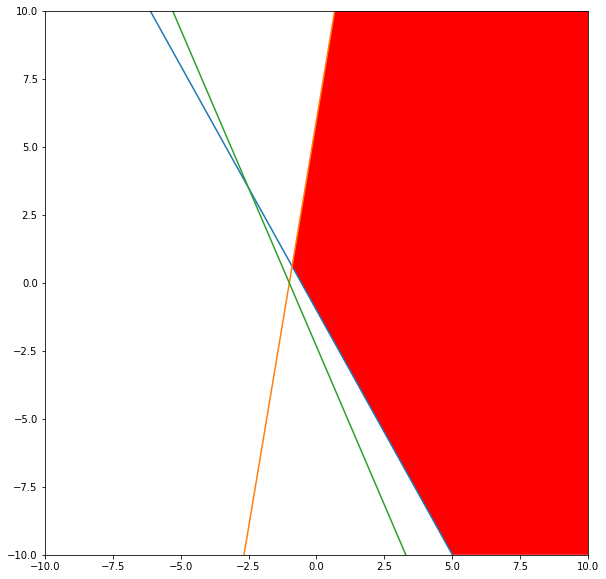

In [7]:
#NOTE: Here Is Just Messing Around and Graphing Of Linear Programs
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy.optimize import linprog

import pulp

def feasible_point(A, b):
    # finds the center of the largest sphere fitting in the convex hull
    norm_vector = np.linalg.norm(A, axis=1)
    A_ = np.hstack((A, norm_vector[:, None]))
    b_ = b[:, None]
    c = np.zeros((A.shape[1] + 1,))
    c[-1] = -1
    res = linprog(c, A_ub=A_, b_ub=b[:, None], bounds=(None, None))
    return res.x[:-1]
    
def hs_intersection(A, b):
    interior_point = feasible_point(A, b)
    halfspaces = np.hstack((A, -b[:, None]))
    hs = HalfspaceIntersection(halfspaces, interior_point)
    return hs

def plt_halfspace(a, b, bbox, ax):
    if a[1] == 0:
        ax.axvline(b / a[0])
    else:
        x = np.linspace(bbox[0][0], bbox[0][1], 100)
        ax.plot(x, (b - a[0]*x) / a[1])

def add_bbox(A, b, xrange, yrange):
    A = np.vstack((A, [
        [-1,  0],
        [ 1,  0],
        [ 0, -1],
        [ 0,  1],
    ]))
    b = np.hstack((b, [-xrange[0], xrange[1], -yrange[0], yrange[1]]))
    return A, b

def solve_convex_set(A, b, bbox, ax=None):
    A_, b_ = add_bbox(A, b, *bbox)
    interior_point = feasible_point(A_, b_)
    hs = hs_intersection(A_, b_)
    points = hs.intersections
    hull = ConvexHull(points)
    return points[hull.vertices], interior_point, hs

def plot_convex_set(A, b, bbox, ax=None):
    # solve and plot just the convex set (no lines for the inequations)
    points, interior_point, hs = solve_convex_set(A, b, bbox, ax=ax)
    if ax is None:
        _, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])
    ax.fill(points[:, 0], points[:, 1], 'r')
    return points, interior_point, hs

def plot_inequalities(A, b, c, bbox, ax=None):
    # solve and plot the convex set,
    # the inequation lines, and
    # the interior point that was used for the halfspace intersections
    points, interior_point, hs = plot_convex_set(A, b, bbox, ax=ax)
    #ax.plot(*interior_point, 'o')
    print(interior_point)
    for a_k, b_k in zip(A, b):
        plt_halfspace(a_k, b_k, bbox, ax)
    return points, interior_point, hs

def generate_linear_program(n, m, lower_entry_bound, upper_entry_bound):

    a_matrix = np.random.randint(lower_entry_bound,upper_entry_bound,size = (m,n))
    b_vector = np.random.randint(lower_entry_bound,upper_entry_bound,size = (m))
    c_vector = np.random.randint(lower_entry_bound,upper_entry_bound,size = (n))

    # Making Ax <= b with b being positive
    for i in range(len(b_vector)):
        if b_vector[i] <= 0:
            b_vector[i] = b_vector[i] * -1
            a_matrix[i] = a_matrix[i] * -1
    
    return (a_matrix, b_vector, c_vector)

n = 2
m = 3

lower_entry_bound = -10
upper_entry_bound = 10

a_matrix, b_vector, c_vector = generate_linear_program(n,m,lower_entry_bound,upper_entry_bound)

print(f'A \n{a_matrix}\n')
print(f'b \n{b_vector}\n')
print(f'c \n{c_vector}\n')

linear_program = pulp.LpProblem("Test Generation", pulp.LpMinimize)
solver = pulp.PULP_CBC_CMD()
#? Have to figure out a way to dynamically generate variables for LP or use a differnt method to check infeasible/unbounded
x1 = pulp.LpVariable('x1', cat='Continuous')
x2 = pulp.LpVariable('x2', cat='Continuous')
linear_program += c_vector[0] * x1 + c_vector[1] * x2, 'Z'
for i in range(len(a_matrix)):
    linear_program += a_matrix[i][0] * x1 + a_matrix[i][1] * x2 <= b_vector[i]
print(linear_program)
result = linear_program.solve(solver)
status = pulp.LpStatus[linear_program.status]
print(status)

plt.rcParams['figure.figsize'] = (10, 10)
bbox = [(-10, 10), (-10, 10)]
fig, ax = plt.subplots()
plot_inequalities(a_matrix, b_vector, c_vector, bbox, ax)